In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
!pip install py7zr
import py7zr
base_path = r'/kaggle/input/favorita-grocery-sales-forecasting/'
files = ['stores','items','holidays_events','transactions','train','oil','sample_submission','test']
files = [base_path+file+'.csv.7z' for file in files]
for file in files:
    temp = py7zr.SevenZipFile(file,'r')
    temp.extractall(path=r'./')
    temp.close()

     |████████████████████████████████| 67 kB 834 kB/s 
     |████████████████████████████████| 2.8 MB 1.8 MB/s 
     |████████████████████████████████| 357 kB 44.3 MB/s 
     |████████████████████████████████| 126 kB 57.2 MB/s 
     |████████████████████████████████| 1.9 MB 69.0 MB/s 
     |████████████████████████████████| 48 kB 3.7 MB/s 


# EDA

In [4]:
items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv",parse_dates=['date'])
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
# Read in the full training data just to get prior information and here is the output:
# Output: "125,497,040 rows | 6 columns"
train = pd.read_csv("train.csv", nrows=6000000, parse_dates=['date'])

In [5]:
train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


**Check null values**

In [6]:
print("Nulls in Oil columns: {0} => {1}".format(oil.columns.values,oil.isnull().any().values))
print("="*70)
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values,holiday_events.isnull().any().values))
print("="*70)
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values,stores.isnull().any().values))
print("="*70)
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values,transactions.isnull().any().values))

Nulls in Oil columns: ['date' 'dcoilwtico'] => [False  True]
Nulls in holiday_events columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]
Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


only one column in Oil has null value

## oil_data

<AxesSubplot:xlabel='date'>

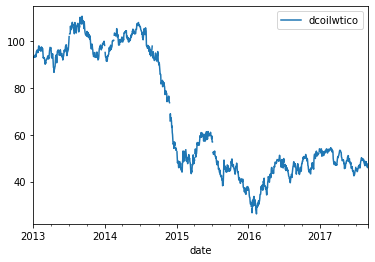

In [7]:
oil.set_index('date').plot()

## stores data

In [8]:
print(stores.head(5))
print(stores.shape)

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
(54, 5)


In [9]:
cluster_ = stores.cluster.unique()
print(sorted(cluster_))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


<AxesSubplot:>

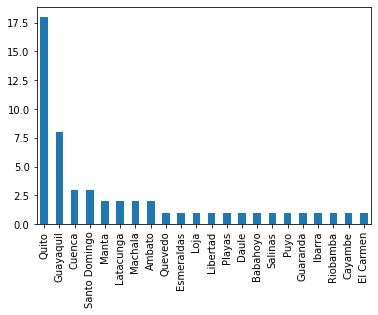

In [10]:
stores.city.value_counts().plot.bar()

<AxesSubplot:>

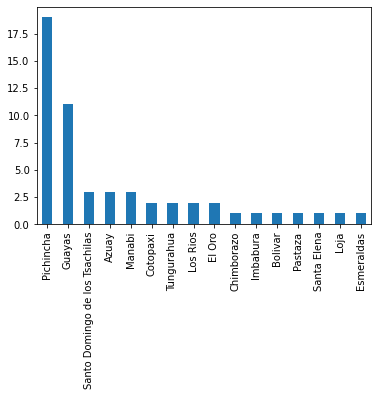

In [11]:
stores.state.value_counts().plot.bar()

In [12]:
stores.cluster.value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

From visualising the store numbers side-by-side based on the clustering, we can identify certain patterns. For example clusters 3, 6, 10 and 15 are the most common store clusters based off the fact that there are more store_nbrs attributed to them then the others while on the other end of the spectrum, we have clusters 5 and 17 which are only related to the stores 44 and 51 respectively.

<AxesSubplot:xlabel='cluster'>

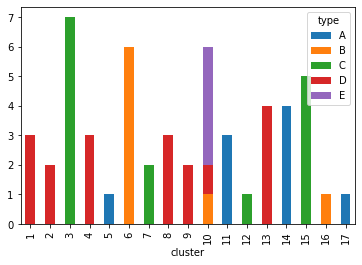

In [13]:
stores.groupby(['cluster','type']).size().unstack().plot(kind='bar',stacked=True)

<AxesSubplot:xlabel='type'>

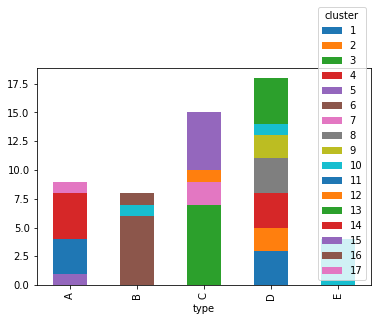

In [14]:
stores.groupby(['type','cluster']).size().unstack().plot(kind='bar',stacked=True)

Most of the store types seem to contain a mix of the clusters,

## holidays_events

In [15]:
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## items

In [16]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


<AxesSubplot:>

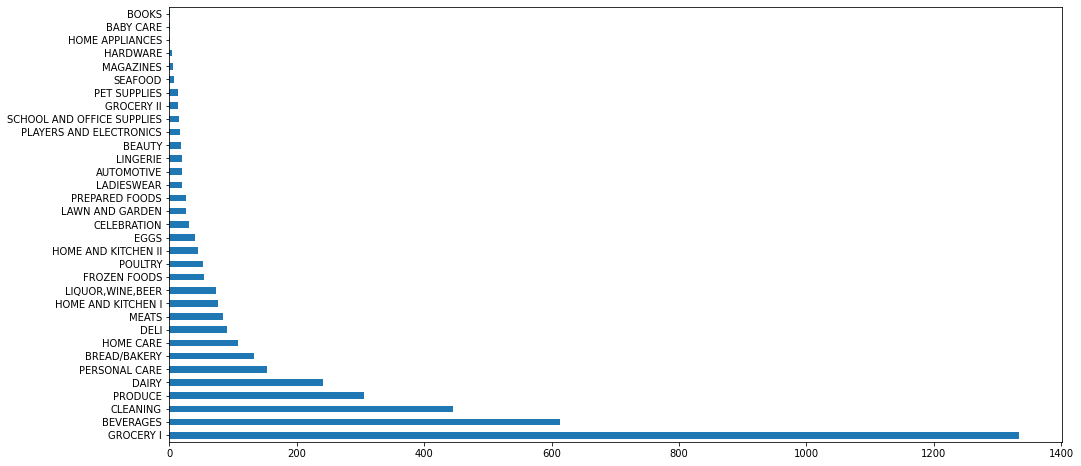

In [17]:
plt.figure(figsize=(16,8))
items.family.value_counts().plot.barh()

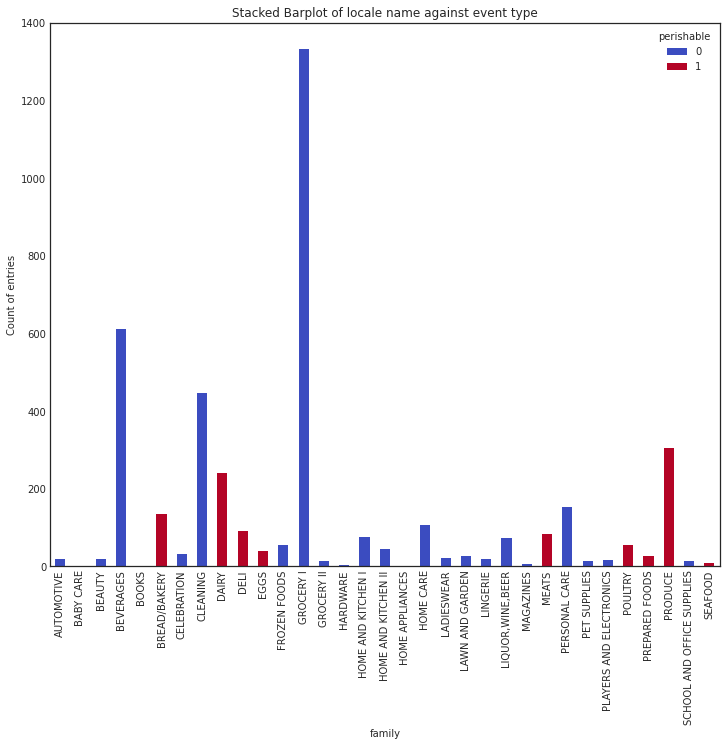

In [18]:
plt.style.use('seaborn-white')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()

## transactions
Inspecting the transactions file, we must be aware that the transactional data is only included for the training timeframe according to the competition's data dictionary. Furthermore the columns in this file relate only to the count of sales transactions for

In [19]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


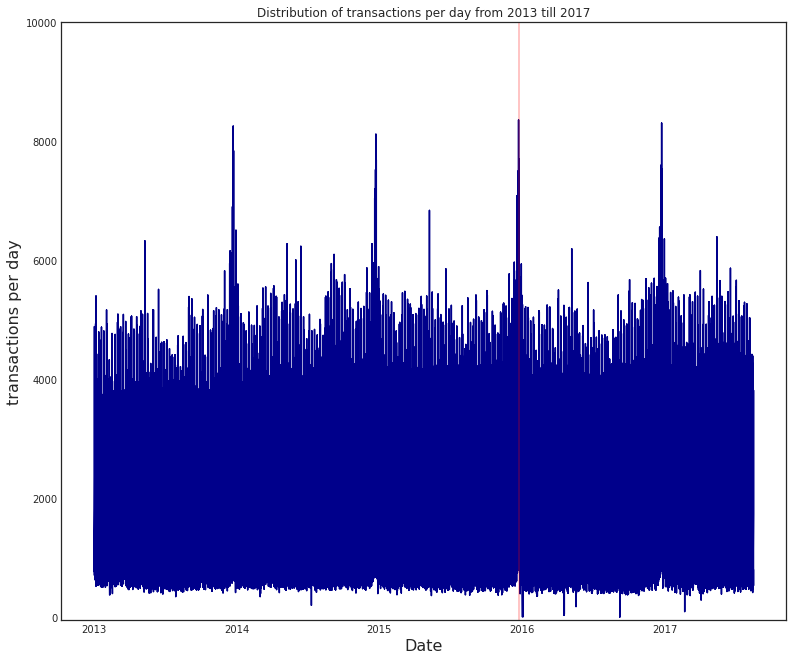

In [20]:
plt.style.use('seaborn-white')
plt.figure(figsize=(13,11))
plt.plot(transactions.date.values, transactions.transactions.values, color='darkblue')
plt.axvline(x=pd.to_datetime('2015-12-23'),color='red',alpha=0.3)
# plt.axvline(x='2016-12-23',color='red',alpha=0.3)
# plt.axvline(x='2014-12-23',color='red',alpha=0.3)
# plt.axvline(x='2013-12-23',color='red',alpha=0.3)
# plt.axvline(x='2013-05-12',color='green',alpha=0.2, linestyle= '--')
# plt.axvline(x='2015-05-10',color='green',alpha=0.2, linestyle= '--')
# plt.axvline(x='2016-05-08',color='green',alpha=0.2, linestyle= '--')
# plt.axvline(x='2014-05-11',color='green',alpha=0.2, linestyle= '--')
# plt.axvline(x='2017-05-14',color='green',alpha=0.2, linestyle= '--')
plt.ylim(-50, 10000)
plt.title("Distribution of transactions per day from 2013 till 2017")
plt.ylabel('transactions per day', fontsize= 16)
plt.xlabel('Date', fontsize= 16)
plt.show()

In [21]:
holiday_events[holiday_events.date=='2013-05-12']

,date,type,locale,locale_name,description,transferred
54,2013-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False


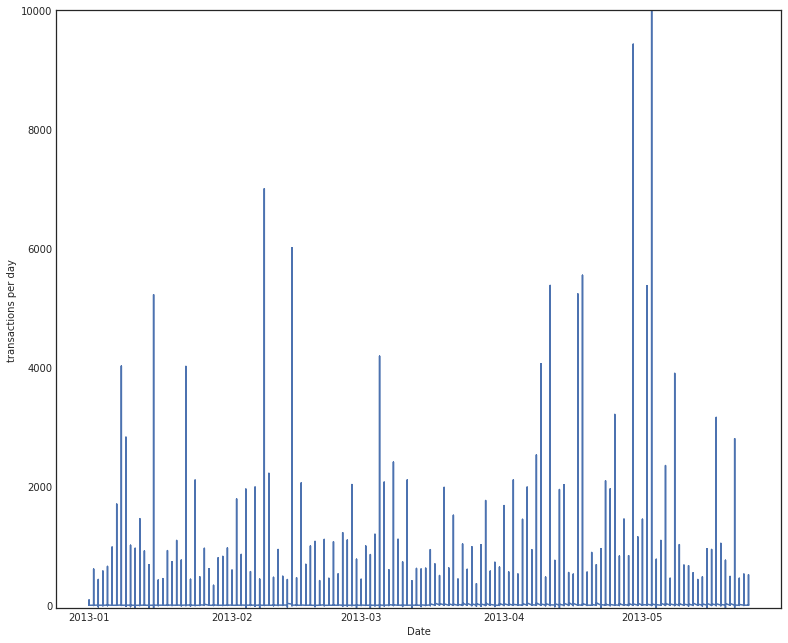

In [22]:
plt.style.use('seaborn-deep')
plt.figure(figsize=(13,11))
plt.plot(train.date.values, train.unit_sales)
plt.ylim(-50, 10000)
plt.ylabel('transactions per day')
plt.xlabel('Date')
plt.show()

# modeling

In [23]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

df_train = pd.read_csv(
    'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_test = pd.read_csv(
    "test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

In [24]:
items = pd.read_csv(
    "items.csv",
).set_index("item_nbr")

df_2017 = df_train[df_train.date.isin(
    pd.date_range("2017-05-31", periods=7 * 11))].copy()
del df_train

In [25]:
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)

In [26]:
promo_2017_train.columns.get_level_values(1)[:3]

DatetimeIndex(['2017-05-31', '2017-06-01', '2017-06-02'], dtype='datetime64[ns]', name='date', freq=None)

In [27]:
promo_2017_train.head(3)

onpromotion                                              \
date                2017-05-31 2017-06-01 2017-06-02 2017-06-03 2017-06-04   
store_nbr item_nbr                                                           
1         96995          False      False      False      False      False   
          99197          False      False      False      False      False   
          103520         False      False      False      False      False   

                                                                           \
date               2017-06-05 2017-06-06 2017-06-07 2017-06-08 2017-06-09   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   

                    ...                                              \
date                ... 2017-08-06 2017-08-07 2017-08-08 2017-08-09   
store_nbr item_nbr  ...                                               
1         96995     ...      False      False      False      False   
          99197     ...      False      False      False      False   
          103520    ...      False      False      False      False   

                                                                           \
date               2017-08-10 2017-08-11 2017-08-12 2017-08-13 2017-08-14   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   

                               
date               2017-08-15  
store_nbr item_nbr             
1         96995         False  
          99197         False  
          103520        False  

[3 rows x 77 columns]

In [28]:
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1) # 本来的columns是元组类型(onpromotion,date)->(date)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)  # 有些商品train里有test没有，所以要让他们的index一致

In [29]:
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train

In [30]:
promo_2017.head(3)

date                2017-05-31  2017-06-01  2017-06-02  2017-06-03  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   

date                2017-06-04  2017-06-05  2017-06-06  2017-06-07  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   

date                2017-06-08  2017-06-09  ...  2017-08-22  2017-08-23  \
store_nbr item_nbr                          ...                           
1         96995          False       False  ...       False       False   
          99197          False       False  ...       False       False   
          103520         False       False  ...       False       False   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995          False       False       False       False  
          99197          False       False       False       False  
          103520         False       False       False       False  

[3 rows x 93 columns]

In [31]:
df_2017.head(3)

,date,store_nbr,item_nbr,unit_sales,onpromotion
50912462,2017-05-31,1,96995,0.693147,False
50912463,2017-05-31,1,99197,0.693147,False
50912464,2017-05-31,1,103520,1.386294,False


In [32]:
df_2017 = df_2017.set_index(  # df_2017 is train set
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0) # 我们列出了所有商品每天的unit_sales,但是有些商品某些天是没有记录的，会出现na
df_2017.columns = df_2017.columns.get_level_values(1)

In [33]:
df_2017.head(3)

date                2017-05-31  2017-06-01  2017-06-02  2017-06-03  \
store_nbr item_nbr                                                   
1         96995       0.693147    0.000000    0.000000    0.000000   
          99197       0.693147    1.386294    1.098612    1.945910   
          103520      1.386294    1.098612    1.098612    0.693147   

date                2017-06-04  2017-06-05  2017-06-06  2017-06-07  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       1.098612    1.098612    0.000000    0.000000   
          103520      0.000000    0.693147    1.609438    0.693147   

date                2017-06-08  2017-06-09  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         96995       0.000000    0.693147  ...    1.098612    1.098612   
          99197       0.693147    0.693147  ...    0.000000    1.098612   
          103520      0.693147    1.098612  ...    0.000000    0.000000   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.693147    0.000000   
          99197       0.000000    1.098612    0.000000    0.000000   
          103520      1.386294    0.000000    1.386294    0.693147   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         96995       0.000000    0.000000         0.0         0.0  
          99197       0.000000    0.000000         0.0         0.0  
          103520      0.693147    0.693147         0.0         0.0  

[3 rows x 77 columns]

In [34]:
items = items.reindex(df_2017.index.get_level_values(1)) # 重新排列货物顺序与df_2017的index货物顺序一致

In [35]:
items.head(3)

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103520,GROCERY I,1028,0


In [36]:
def get_timespan(df, dt, minus, periods):
    """
    dt:2017-06-21,minus:3,periods:3
    ->['2017-06-18', '2017-06-19', '2017-06-20']
    取出df这三天的unit_sales
    """
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values, # 过去3天各个货物的平均unit_sales
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values # 过去14天做促销的次数
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[pd.to_datetime( # 之后16天的促销情况,因为我们要预测的target是未来16天的促销情况
            t2017 + timedelta(days=i)
        )].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16) # 之后16天的unit_sales
        ].values
        return X, y
    return X  # 如果是test则返回这个

In [37]:
print("Preparing dataset...")
t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4): 
    delta = timedelta(days=7 * i)  # date(2017, 6, 21) -> date(2017, 7, 12)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)  # 看上去行很长，实际上只选取了4天作为样本
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False) # 从8-16开始预测未来16天

Preparing dataset...


In [38]:
print("Training and predicting models...")
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression_l2',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
for i in range(16): # 只能一个一个训练
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * 4) * 0.25 + 1 # 因为训练集样本是4天，所以重复4次,腐败的权重多0.25
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))
"""
df_test[["id"]] # df_test中，每家店列出来的商品都是一样的，且每天都全部记录一次
df_preds # 每种商品只列举了一次,第一家商店，16天的单价
156790 每家商店的所有item列表 ，156790*16天的单价->2508640
"""
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('submission.csv', float_format='%.4f', index=None)

Training and predicting models...
Step 1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 627160, number of used features: 20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 1.096796
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.345337	valid_1's l2: 0.341407
[100]	training's l2: 0.333268	valid_1's l2: 0.33001
[150]	training's l2: 0.33125	valid_1's l2: 0.328701
[200]	training's l2: 0.330228	valid_1's l2: 0.328227
[250]	training's l2: 0.329363	valid_1's l2: 0.327916
[300]	tr